### Project 2: RNNs

This is the second project in NLP SW05 done by Jannine Meier. 

The project was run on GPUHub.

WandB: 
- https://wandb.ai/nlp_janninemeier/Project2_Winogrande
- https://wandb.ai/nlp_janninemeier/Project2_Anagram
- https://wandb.ai/nlp_janninemeier/Project2_Palindrome

#### Imports

In [17]:
# Install libraries
!pip install numpy pandas torch datasets transformers wandb matplotlib scikit-learn

In [18]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim import Adam
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import copy

# Set seed for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    torch.cuda.manual_seed_all(seed_value)  # PyTorch, if you are using CUDA
set_seed(42)

#### Dataloading
The datasets are loaded and split into training, validation, and test sets.

Winogrande is split by excluding the last 1000 entries from the full training dataset and form the test set with it.

In [19]:
# Load Winogrande dataset
def load_winogrande_dataset():
    winogrande_dataset = load_dataset('winogrande', 'winogrande_l')
    wg_train_dataset = winogrande_dataset['train'].select(range(len(winogrande_dataset['train']) - 1000))
    wg_val_dataset = winogrande_dataset['validation']
    wg_test_dataset = winogrande_dataset['train'].select(range(len(winogrande_dataset['train']) - 1000, len(winogrande_dataset['train'])))
    return wg_train_dataset, wg_val_dataset, wg_test_dataset

# Go to the direcotry where the anagram and palindrome datasets are saved (needs to be adjusted if code has to be reproduced)
%pwd
%cd 'NLP/SW05'
%pwd

# Load anagram dataset
def load_anagram_dataset(train_path, valid_path, test_path):
    anagram_train = pd.read_csv(train_path, header=None, names=['sequence', 'label'])
    anagram_valid = pd.read_csv(valid_path, header=None, names=['sequence', 'label'])
    anagram_test = pd.read_csv(test_path, header=None, names=['sequence', 'label'])
    return anagram_train, anagram_valid, anagram_test

# Load palindrome dataset
def load_palindrome_dataset(train_path, valid_path, test_path):
    palindrome_train = pd.read_csv(train_path, header=None, names=['text', 'label'])
    palindrome_valid = pd.read_csv(valid_path, header=None, names=['text', 'label'])
    palindrome_test = pd.read_csv(test_path, header=None, names=['text', 'label'])
    return palindrome_train, palindrome_valid, palindrome_test

[Errno 2] No such file or directory: 'NLP/SW05'
/home/jovyan/NLP/SW05


#### Choose dataset for the run

In [20]:
# Choose which dataset to load and print some entries
dataset_choice = 'palindrome'  # Change this variable to switch between datasets

if dataset_choice == 'winogrande':
    wg_train_dataset, wg_val_dataset, wg_test_dataset = load_winogrande_dataset()
    print(wg_train_dataset[:1])
    print("Length train set:", len(wg_train_dataset))
    print("Length val set:",len(wg_val_dataset))
    print("Length test set:",len(wg_test_dataset))
elif dataset_choice == 'anagram':
    anagram_train, anagram_valid, anagram_test = load_anagram_dataset('anagram_train.csv', 'anagram_valid.csv', 'anagram_test.csv')
    print(anagram_train.head())
    print("Length train set:", len(anagram_train))
    print("Length val set:", len(anagram_valid))
    print("Length test set:", len(anagram_test))

elif dataset_choice == 'palindrome':
    palindrome_train, palindrome_valid, palindrome_test = load_palindrome_dataset('palindrome_train.csv', 'palindrome_valid.csv', 'palindrome_test.csv')
    print(palindrome_train.head())
    print("Length train set:",len(palindrome_train))
    print("Length val set:",len(palindrome_valid))
    print("Length test set:",len(palindrome_test))
else:
    print("Invalid dataset choice")

                  text  label
0    j q f m m s f q j      0
1      v y f u u f y v      1
2          a c c k k a      0
3  v y d m e w m t y v      0
4            l s j j l      0
Length train set: 1000
Length val set: 500
Length test set: 500


#### Preprocessing

**Winogrande dataset**
- I start by replacing a placeholder in the sentences same as I did in the last project.
- Next, I tokenize these sentences with the BertTokenizer. With the tokenizer I convert the text to tokens (lowercase words). Then I apply padding and truncation to ensure uniform length and use a maximum length of 128 to keep the data manageable. I chose the maximum length because the mean of the sentence sizes is around 90, so we do not waste too much computation on padding tokens even though the acutal max size of the datasets is 186.
- The conversion of labels from '1' and '2' to 0 and 1 is a done because it is a binary classification task and it aligns with the  format used later in my code.
- Concatenating the input_ids to form a single input sequence for each example. To avoid that my model interprets them as two separate sequences, I remove the first token of the second sequence (the duplicated [CLS] token) before concatenation. I tested and ensured that the concatenated result does not exceed the model's maximum sequence length. 

**Anagram and Palindrome dataset**
- I've chosen to implement a custom CharTokenizer, which makes sense because character-level features are important for these tasks. It maps each character to a unique integer ID and sets a special entry for padding, mapped to the ID 0 which is used to pad sequences to uniform lengths during tokenization (the padding itself is done later in the custom_collate_fn function).
- For anagram I split the sequence into two parts at the separator and tokenize each part separately by removing spaces. The two results, as well as the separator which I mapped to ID 1 are then combined. As discussed shortly during class it is important to not remove the seperator in order to preserve the structure for analyizing if it is an anagram. 
- For palindrome I tokenize the entire sequence as one single unit by removing spaces.


In [21]:

# Preprocess Winogrande dataset
def preprocess_winogrande_dataset(dataset, tokenizer):
    def preprocess_function(examples):
        # Replace the blank with each option and create two sequences
        first_sentences = [sentence.replace('_', option) for sentence, option in zip(examples['sentence'], examples['option1'])]
        second_sentences = [sentence.replace('_', option) for sentence, option in zip(examples['sentence'], examples['option2'])]
        # Tokenize both sets of sequences
        first_tokenized = tokenizer(first_sentences, padding='max_length', truncation=True, max_length=128)
        second_tokenized = tokenizer(second_sentences, padding='max_length', truncation=True, max_length=128)
        # Convert labels '1' and '2' in examples['answer'] to 0 and 1
        converted_labels = [int(label) - 1 for label in examples['answer']]
        # Prepare the final features 
        features = {
            'input_ids': [first_tokenized['input_ids'][i] + second_tokenized['input_ids'][i][1:] for i in range(len(examples['sentence']))],  # Remove first token of the second sequence to avoid duplicating CLS
            'labels': converted_labels
        }
        return features
    
    return dataset.map(preprocess_function, batched=True)


class CharTokenizer:
    def __init__(self):
        # Initialize with a padding token
        self.char_to_id = {"[PAD]": 0, "<sep>": 1}  # Add separator token
        self.id_to_char = {0: "[PAD]", 1: "<sep>"}  # Reverse mapping

    def tokenize(self, text):
        tokenized_text = []
        for char in text:
            if char not in self.char_to_id:
                char_id = len(self.char_to_id)
                self.char_to_id[char] = char_id
                self.id_to_char[char_id] = char
            tokenized_text.append(self.char_to_id[char])
        return tokenized_text

# Preprocess anagram or palindrome dataset
def preprocess_dataset(dataframe, tokenizer, is_palindrome=False):
    processed_data = []
    for index, row in dataframe.iterrows():
        sequence, label = row[0], int(row[1])
        if is_palindrome:
            tokenized_sequence = tokenizer.tokenize(sequence.replace(' ', ''))
            processed_data.append((tokenized_sequence, label))
        else:
            part1, part2 = sequence.split('<sep>')
            tokenized_part1 = tokenizer.tokenize(part1.replace(' ', ''))
            separator_token = [1]
            tokenized_part2 = tokenizer.tokenize(part2.replace(' ', ''))
            processed_data.append((tokenized_part1 + separator_token + tokenized_part2, label))
            
    return processed_data

    
# Choose which dataset to preprocess
if dataset_choice == 'winogrande':
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    wg_train_dataset = preprocess_winogrande_dataset(wg_train_dataset, tokenizer)
    wg_val_dataset = preprocess_winogrande_dataset(wg_val_dataset, tokenizer)
    wg_test_dataset = preprocess_winogrande_dataset(wg_test_dataset, tokenizer)
    # Show a sample
    print("Preprocessed winogrande training sample input_ids (padded):", wg_train_dataset['input_ids'][0])
    print("Preprocessed winogrande training sample labels:", wg_train_dataset['labels'][0])
    print("Vocabulary size:", len(tokenizer.vocab))

elif dataset_choice == 'anagram':
    tokenizer = CharTokenizer() 
    anagram_train_features = preprocess_dataset(anagram_train, tokenizer, is_palindrome=False)
    anagram_valid_features = preprocess_dataset(anagram_valid, tokenizer, is_palindrome=False)
    anagram_test_features = preprocess_dataset(anagram_test, tokenizer, is_palindrome=False)
    # Show a sample
    print("Preprocessed anagram training sample sequence (not yet padded, seperated by ID 1):", anagram_train_features[0][0])
    print("Preprocessed anagram training sample label:", anagram_train_features[0][1])
    print("Vocabulary size:", len(tokenizer.char_to_id))
    
elif dataset_choice == 'palindrome':
    tokenizer = CharTokenizer()
    palindrome_train_features = preprocess_dataset(palindrome_train, tokenizer, is_palindrome=True)
    palindrome_valid_features = preprocess_dataset(palindrome_valid, tokenizer, is_palindrome=True)
    palindrome_test_features = preprocess_dataset(palindrome_test, tokenizer, is_palindrome=True)
    # Show a sample
    print("Preprocessed palindrome training sample label:", palindrome_train_features[0][1])
    print("Preprocessed palindrome training sample sequence (not yet padded):", palindrome_train_features[1][0])
    print("Vocabulary size:", len(tokenizer.char_to_id))

Preprocessed palindrome training sample label: 0
Preprocessed palindrome training sample sequence (not yet padded): [7, 8, 4, 9, 9, 4, 8, 7]
Vocabulary size: 28


/tmp/ipykernel_7760/2802681824.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence, label = row[0], int(row[1])


#### Configurations

I tried out different settings for my runs to get high accuracies ranging from:
- I used a learning_rate of 1e-2 to 1e-5 as these are common values for hyperparametertuning.
- I set epochs up to 100 for winogrande and up to 500 for anagram/palindrome. I limited this because of the time consumption in regards to this project. Another reason for the limiting was that I got overfitting already after early epochs so I came to conlusion to go with 50 epochs for Winogrande and 250 for the other two datasets. 
- I set the train_batch_size as big as possible without running into memory error (of course still considering that very large batch sizes can lead to poorer generalization but I was not able to go over 64 anyway because of memory).
- I worked with different embedding_dim and hidden_dim ranging from 64 to 51.
- I used dropout between 0.1 to 0.3 to prevent overfitting. As I saw a lot of overfitting I used the 0.3 for my final runs. 
- The input_dim is either the vocabulary size from the CharTokenizer dictionary or the one from BertTokenizer so it fits the dataset which is important.

In [22]:
#  Weights & Biases configuration of hyperparameters
default_config = {
    "learning_rate": 1e-2,
    "epochs": 250,
    "train_batch_size": 32,
    "eval_batch_size": 64,
    "test_batch_size": 64,
    "embedding_dim": 64, 
    "hidden_dim":64, 
    "num_layers": 2,
    "dropout": 0.3, 
    "input_dim": None # Is updatet depending on the used dataset/tokenizer
}

# Initialize Weights & Biases
wandb.init(project="Project2_Palindrome", config=default_config)
config = wandb.config

# Update input_dim based on tokenizer's vocabulary
if hasattr(tokenizer, 'vocab'):
    config.update({"input_dim": len(tokenizer.vocab)}, allow_val_change=True)

else:
    config.update({"input_dim": len(tokenizer.char_to_id)}, allow_val_change=True)
 

best_valid_acc,▁████
epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▃▁▇█▂
train_loss,█▃▁▂▁
valid_acc,▁██▁█
valid_loss,█▁▃▅▁
best_valid_acc,0.50434
epoch,4
test_accuracy,0.5
train_acc,0.49459


#### Model

Here I instantiate a recurrent neural network classifier which is designed for binary classification tasks and chose an LSTM layer as its core component for handling sequences. As you suggested, I chose nn.Embedding to convert letters, words etc. into vectors.

As most of my inputs are padded, the last hidden layer entries are mostly all zeros which do not really represent the data. Therefore I ignore the padding by taking the packed embeddings and the actual lengths of each sequence (text_lengths) to produce a packed sequence. 

In [23]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)  # batch_size x seq_len x embedding_dim

        # Pack the sequence of embeddings
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.rnn(packed_embedded)
        
        # We only need the last hidden state
        hidden = hidden[-1].squeeze(0)  # Final hidden state of the last layer

        output = self.classifier(hidden)
        return output
    

# Instantiate the model
model = RNNClassifier(
    input_dim=config.input_dim,
    embedding_dim=config.embedding_dim,
    hidden_dim=config.hidden_dim,
    output_dim=1,  # Binary classification
    num_layers=config.num_layers,
    dropout=config.dropout
)

#### Set up

I chose the BCEWithLogitsLoss with an already integrated sigmoid layer because it's specifically designed for binary classification tasks.

I chose the Adam optimizer which is a common choice for such tasks.

In [24]:

# Loss function
loss_function = nn.BCEWithLogitsLoss() 

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# We can check if a GPU is available and move our model there
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


#### Dataloader

**Custom Collate Function**:
For BertTokenizer data in dictionary format, it assembles input_ids into tensors, stacks them, and creates a tensor for the labels (it was already padded during preprocessing so the pad_sequence does not make a difference here).
For CharTokenizer data in tuple format, it pads sequences to ensure uniform length to the longest sequence in the batch. I intentionally do not take the mean length of sequences to pad (as I did for the Winogrande dataset) because here I want to always have the full sequence as otherwise the model has not really a chance to learn successfully.

**DataLoader**:
I shuffle (only) the train sets to ensure randomness, which can help improve my model generalization.

In [25]:
# Define the DataLoaders for the training, validation, and test sets
train_batch_size = config.train_batch_size
eval_batch_size = config.eval_batch_size
test_batch_size = config.test_batch_size


def custom_collate_fn(batch):
    # For both BERT-like tokenized data and CharTokenizer data
    input_ids, labels = zip(*[(item['input_ids'] if 'input_ids' in item else item[0], item['labels'] if 'labels' in item else item[1]) for item in batch])
    input_ids = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids], batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.float)
    
    # Calculate sequence lengths by counting non-zero entries (non-padding tokens)
    sequence_lengths = torch.tensor([seq.gt(0).sum() for seq in input_ids], dtype=torch.long)

    return {'input_ids': input_ids, 'labels': labels, 'sequence_lengths': sequence_lengths}



class CustomDataset(Dataset):
    def __init__(self, data):
        # data is expected to be a list of tuples (sequence, label)
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        # Convert sequence and label into PyTorch tensors
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.float)
        return sequence_tensor, label_tensor

# Choose which dataset to create DataLoader for
if dataset_choice == 'winogrande':
    train_loader = DataLoader(wg_train_dataset, train_batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(wg_val_dataset, eval_batch_size, shuffle=False, collate_fn=custom_collate_fn)
    test_loader = DataLoader(wg_test_dataset, test_batch_size, shuffle=False, collate_fn=custom_collate_fn)
elif dataset_choice == 'anagram':
    train_loader = DataLoader(CustomDataset(anagram_train_features), train_batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(CustomDataset(anagram_valid_features), eval_batch_size, shuffle=False, collate_fn=custom_collate_fn)
    test_loader = DataLoader(CustomDataset(anagram_test_features), test_batch_size, shuffle=False, collate_fn=custom_collate_fn)
elif dataset_choice == 'palindrome':
    train_loader = DataLoader(CustomDataset(palindrome_train_features), train_batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(CustomDataset(palindrome_valid_features), eval_batch_size, shuffle=False, collate_fn=custom_collate_fn)
    test_loader = DataLoader(CustomDataset(palindrome_test_features), test_batch_size, shuffle=False, collate_fn=custom_collate_fn)



#### Train and Validate loop

Here I pass input data through the train and validation model to get predictions and compute the loss between predictions and actual labels.

Before the train model goes through a backward pass, I zeroe the gradients to prevent accumulation from previous iterations.

Finally, both train and validation return the average loss and accuracy for the epoch.

In [26]:
def train(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    total = 0

    for batch in iterator:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        sequence_lengths = batch['sequence_lengths'].to(device)
        predictions = model(input_ids, sequence_lengths).squeeze(1)

        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Convert logits to probabilities for binary classification
        predicted_probs = torch.sigmoid(predictions)
        predicted = (predicted_probs >= 0.5).long()  # Threshold predictions at 0.5
        total += labels.size(0)
        epoch_correct += (predicted == labels).sum().item()

    return epoch_loss / len(iterator), epoch_correct / total

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    total = 0

    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            sequence_lengths = batch['sequence_lengths'].to(device)
            predictions = model(input_ids, sequence_lengths).squeeze(1)

            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            predicted_probs = torch.sigmoid(predictions)
            predicted = (predicted_probs >= 0.5).long()  
            total += labels.size(0)
            epoch_correct += (predicted == labels).sum().item()

    return epoch_loss / len(iterator), epoch_correct / total


#### Initialization

The loop iterates over the specified number of epochs.

If the validation loss is lower than the previously recorded best validation loss (best_valid_loss), the model's weights are deep-copied and stored (best_model_wts).

After all epochs, the best model weights are saved to a file named 'best_model.pt' and also saved on wandb.

In [27]:
# Training loop
best_valid_loss = float("inf")

for epoch in range(config.epochs):
    # Training and validation
    train_loss, train_acc = train(model, train_loader, optimizer, loss_function, device) 
    valid_loss, valid_acc = evaluate(model, val_loader, loss_function, device) 

    # Checkpointing
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    # Log metrics
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": valid_loss,
        "valid_acc": valid_acc,
        "best_valid_acc": max(valid_acc, wandb.run.summary.get("best_valid_acc", 0))
    })

    print(f'Epoch {epoch+1}/{config.epochs}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.20f}%')

# Save the model checkpoint
torch.save(best_model_wts, 'best_model.pt')
wandb.save('best_model.pt')

/tmp/ipykernel_7760/2804166533.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids], batch_first=True, padding_value=0)


Epoch 1/250
Train Loss: 0.697 | Train Acc: 49.70%
Val Loss: 0.695 | Val Acc: 50.60000000000000142109%
Epoch 2/250
Train Loss: 0.686 | Train Acc: 57.20%
Val Loss: 0.692 | Val Acc: 52.60000000000000142109%
Epoch 3/250
Train Loss: 0.664 | Train Acc: 60.90%
Val Loss: 0.688 | Val Acc: 50.60000000000000142109%


Epoch 4/250
Train Loss: 0.621 | Train Acc: 67.80%
Val Loss: 0.727 | Val Acc: 51.60000000000000142109%
Epoch 5/250
Train Loss: 0.548 | Train Acc: 72.90%
Val Loss: 0.785 | Val Acc: 52.80000000000000426326%
Epoch 6/250
Train Loss: 0.496 | Train Acc: 77.60%
Val Loss: 0.870 | Val Acc: 51.80000000000000426326%
Epoch 7/250
Train Loss: 0.407 | Train Acc: 82.00%
Val Loss: 0.965 | Val Acc: 55.00000000000000710543%
Epoch 8/250
Train Loss: 0.379 | Train Acc: 83.00%
Val Loss: 1.058 | Val Acc: 52.60000000000000142109%
Epoch 9/250
Train Loss: 0.315 | Train Acc: 86.70%
Val Loss: 1.150 | Val Acc: 57.39999999999999857891%
Epoch 10/250
Train Loss: 0.271 | Train Acc: 88.90%
Val Loss: 1.162 | Val Acc: 53.60000000000000142109%
Epoch 11/250
Train Loss: 0.237 | Train Acc: 90.70%
Val Loss: 1.324 | Val Acc: 54.20000000000000284217%
Epoch 12/250
Train Loss: 0.201 | Train Acc: 92.10%
Val Loss: 1.227 | Val Acc: 55.00000000000000710543%
Epoch 13/250
Train Loss: 0.173 | Train Acc: 92.90%
Val Loss: 1.452 | Val Acc: 5

['/home/jovyan/NLP/SW05/wandb/run-20240321_225035-r8hr7uyv/files/best_model.pt']

#### Testing

In [28]:
# Checking test data set
print("Number of test batches:", len(test_loader))
# Optionally, inspect a single batch
for batch in test_loader:
    print(batch)
    break


Number of test batches: 8
{'input_ids': tensor([[ 3, 13, 13,  3,  0,  0,  0,  0,  0,  0],
        [ 2, 12, 12,  0,  0,  0,  0,  0,  0,  0],
        [ 8, 22, 27,  4, 26, 26,  4, 27, 22,  8],
        [17, 22, 22, 22, 22, 17,  0,  0,  0,  0],
        [21,  4,  4, 21,  0,  0,  0,  0,  0,  0],
        [24, 18, 22, 22, 18, 24,  0,  0,  0,  0],
        [18, 26, 18, 26,  0,  0,  0,  0,  0,  0],
        [ 3,  7, 12, 12,  7,  3,  4,  0,  0,  0],
        [ 2, 25, 14, 14, 25, 13, 13,  2,  0,  0],
        [27, 18,  8, 16, 16, 26, 18, 14,  0,  0],
        [ 5, 22,  5, 22,  0,  0,  0,  0,  0,  0],
        [16, 12, 12, 16,  0,  0,  0,  0,  0,  0],
        [26,  2, 11, 12, 12, 11,  7, 26,  0,  0],
        [10, 26, 11, 11, 10, 26,  0,  0,  0,  0],
        [13,  5,  5, 13,  0,  0,  0,  0,  0,  0],
        [19, 20,  5, 20, 26, 26, 20,  5, 20, 19],
        [21,  8, 23, 23,  8, 21,  0,  0,  0,  0],
        [ 3, 15,  6,  5,  6,  6, 15,  3,  0,  0],
        [14, 26,  3, 21, 21,  3, 26, 14,  0,  0],
        [1

/tmp/ipykernel_7760/2804166533.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids], batch_first=True, padding_value=0)


Testing started


/tmp/ipykernel_7760/2804166533.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids], batch_first=True, padding_value=0)


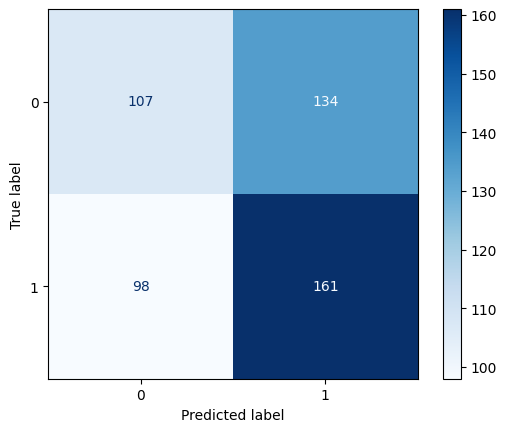

Test Accuracy: 50.32%
Finished testing
Test Accuracy: 50.32%


In [29]:
def test(model, test_loader, device):
    print("Testing started")
    model.eval()
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            sequence_lengths = batch['sequence_lengths'].to(device)
            
            output = model(inputs, sequence_lengths)
            preds = torch.sigmoid(output).round().cpu().numpy()
            
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)
            
    # Calculate metrics such as accuracy
    accuracy = (np.array(predicted_labels) == np.array(true_labels)).mean()

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Log the confusion matrix as an image and test accuracy to Weights & Biases
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues, ax=ax)
    plt.show()  # Ensure the plot is shown in the notebook
    
    wandb.log({"confusion_matrix": wandb.Image(fig), "test_accuracy": accuracy})

    # Print the test accuracy
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print("Finished testing")
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return true_labels, predicted_labels


true_labels, predicted_labels = test(model, test_loader, device)


#### Interpretation

##### Winogrande

My model is predicting all samples as belonging to either all in class 0 or all in class 1, regardless of the true label. As not even the train accuracy improves over time, my model seems not to learn anything useful from the input provided. I tried out multiple learning rates and hidden/embedding layers but still could not manage to improve the outcome. Maybe longer epochs would help but as I have not really seen the validation loss change a lot, this probably would not help too much. A poor choice of random seed can sometimes lead to unfortunate initializations that lead to poor performance, but I also tried different ones here so this is less likely. It could be that the task is still just too complex for a 2-layer RNN and we might need some more layers or better preprocessing approaches. So unfortunately I was only able to get a test accuracy of 50%.


##### Anagram
Most of my loss function do not decrease but under certain configuration I see the validation and train loss decrease slightly (e.g. 1e-2 and hidden_layers dim as well as embedding_layers dim 128) which is a good sign that the model is at least learning something. Nevertheless my model already strongly overfits to the train set after about 20 epochs. This means that I probably could have taken a lower epoch size than 500 but I kept it as I still saw some improvment in the validation accuracy in later epochs. On my test set I got an accuracy of 50.07% based on my best model. This accuracy is pretty low compared to the validation accuracy and therefore it seems like the model was too overfitted and does not generalize well on unseen data.

Some other take-aways: In the beginning I was doing a mistake and removed the seperator token from the vocabulary but later on realized that I should keep these for this task as they are essential. I also started training at the beginning with a fixed vocabulary size of 45 which I roughly estimated but I should have started right at the beginning with the actual length of vocabulary.

##### Palindrome
For the palindrome set I discovered almost the same things as for the anagram. It also overfits to the train set very early, after about 15 epochs and test accuracy is very low with only 50.32% which is only slightly better than guessing. 

Further steps for both of these datasets would be to try out more hyperparameter tuning - especially a higher dropout could help with the overfitting. For both data sets more data could also be useful as 1000 training samples is not a lot for such tasks. Maybe I would have to preprocess the data differently and could get better results as well. Also looking again at the model architecture could maybe show what else I can improve apart from removing the padding again.

I used ChatGPT to help me completing my code.